# Task 7 - Stock Market Prediction using
# Numerical and Textual Analysis 

By - Utkarsh Singhal

Objective: The task objective is to create a hybrid model for stock price/performance
prediction using numerical analysis of historical stock prices, and
sentimental analysis of news headlines

In [1]:
#importing libraries for the purpose of forecasting
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime
import pandas_datareader as web
from pandas.plotting import lag_plot
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 10, 6




In [2]:
#importing libraries for the purpose of sentiment analysis of news headlines
import datetime as dt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
import nltk

In [3]:
#Specifying time-period
startdate = '2017-01-01'
today = datetime.today().strftime('%Y-%m-%d')

In [4]:
# Extracting data
def getMyPortfolio(stocks = "^NSEBANK" ,start = startdate , end = today):
    data = web.DataReader(stocks , data_source='yahoo' , start = start ,end= end )
    return data

In [5]:
df = getMyPortfolio()
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,18115.050781,17830.949219,18002.750000,18035.599609,0.0,18035.599609
2017-01-04,18092.849609,17868.900391,18037.449219,17891.000000,0.0,17891.000000
2017-01-05,18164.050781,17977.800781,18000.750000,18115.949219,0.0,18115.949219
2017-01-06,18325.500000,18157.300781,18168.449219,18264.000000,0.0,18264.000000
2017-01-09,18373.099609,18256.150391,18314.250000,18286.650391,0.0,18286.650391
...,...,...,...,...,...,...
2021-04-12,31698.050781,30520.300781,31637.900391,30792.000000,0.0,30792.000000
2021-04-13,31885.449219,30722.849609,30901.800781,31771.599609,0.0,31771.599609
2021-04-15,32187.050781,31406.400391,31929.099609,32112.849609,0.0,32112.849609


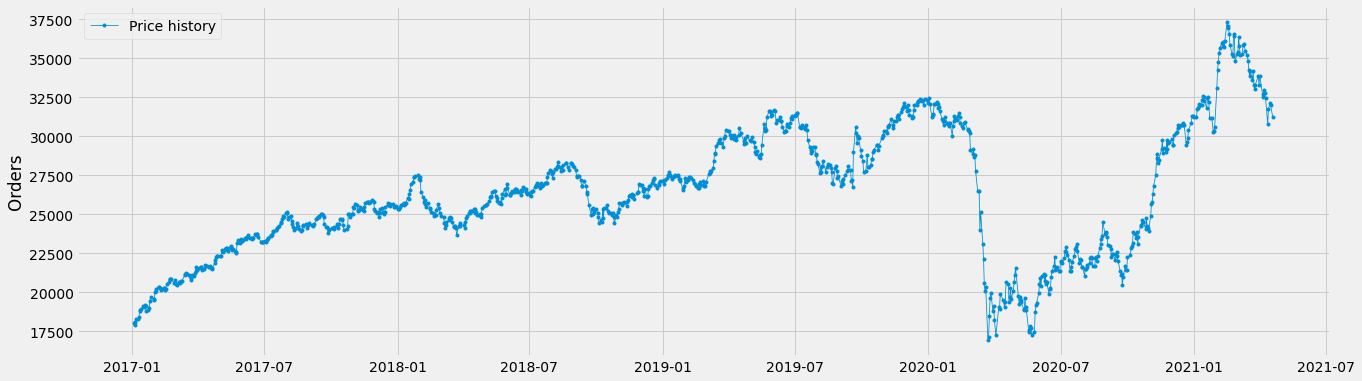

In [6]:
#Plotting Close Prices
y = df['Close']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.8, label='Price history')
ax.set_ylabel('Orders')
ax.legend()

In [7]:
# seasonal decomposition:
'''
Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.
'''
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq',period=1)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

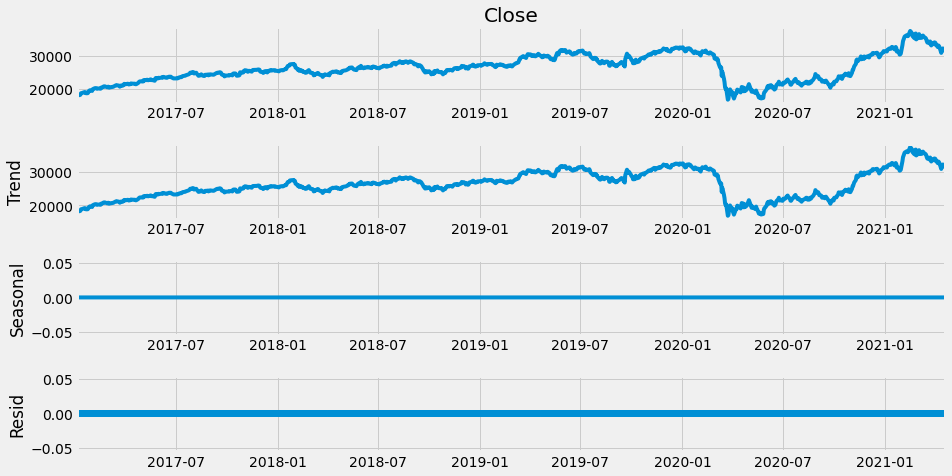

In [8]:
seasonal_decompose(y)

In [9]:
y

Date
2017-01-03    18035.599609
2017-01-04    17891.000000
2017-01-05    18115.949219
2017-01-06    18264.000000
2017-01-09    18286.650391
                  ...     
2021-04-12    30792.000000
2021-04-13    31771.599609
2021-04-15    32112.849609
2021-04-16    31977.449219
2021-04-19    31208.400391
Name: Close, Length: 1052, dtype: float64

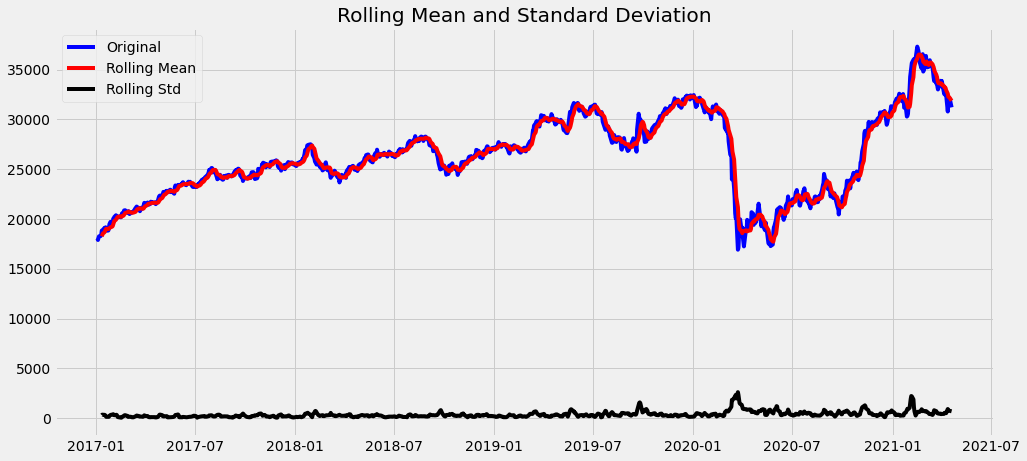

In [10]:
#Stationarity is quintessential in a Time Series Model since ARIMA model works
#best when the predictors are not correlated and are independent of each other. 
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15,7))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
test_stationarity(y)

In [11]:
def ADF_test(timeseries, dataDesc):
    print('Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [12]:
ADF_test(y,'data')

Is the data stationary ?
Test statistic = -2.405
P-value = 0.140
Critical values :
	1%: -3.4366900467481667 - The data is not stationary with 99% confidence
	5%: -2.8643392574735627 - The data is not stationary with 95% confidence
	10%: -2.568260441619371 - The data is not stationary with 90% confidence


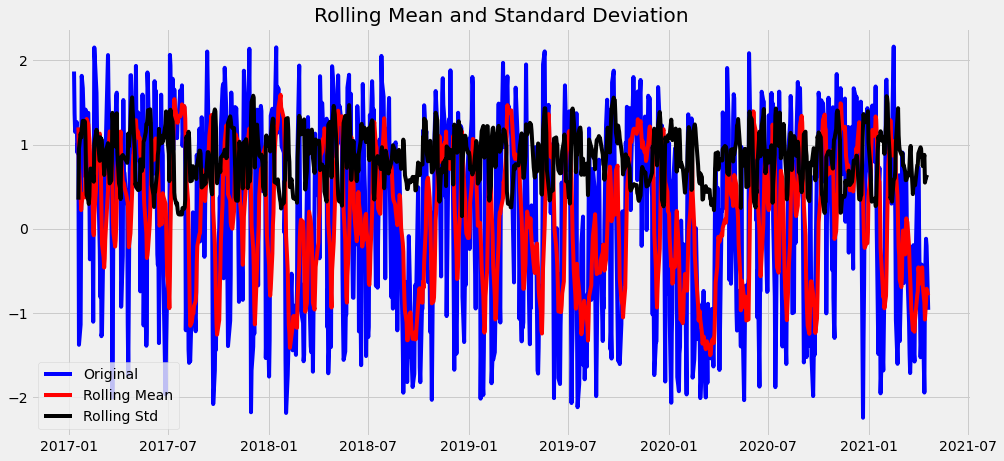

Is the de-trended data stationary ?
Test statistic = -13.838
P-value = 0.000
Critical values :
	1%: -3.43662916802936 - The data is  stationary with 99% confidence
	5%: -2.864312406409634 - The data is  stationary with 95% confidence
	10%: -2.5682461404339336 - The data is  stationary with 90% confidence


In [13]:
# detrending the data to make it stationary
y_detrend =  (y - y.rolling(window=7).mean())/y.rolling(window=7).std()

test_stationarity(y_detrend)
ADF_test(y_detrend,'de-trended data')

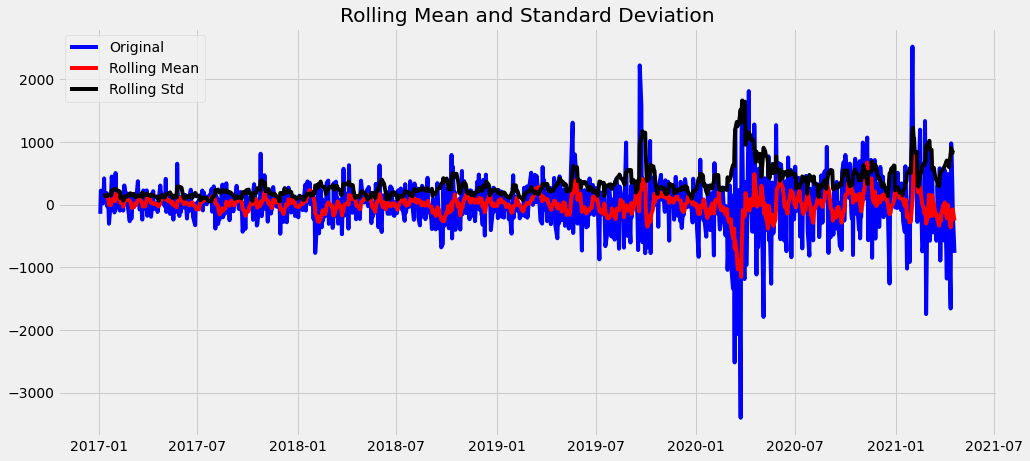

Is the 1st diffrence data stationary ?
Test statistic = -6.901
P-value = 0.000
Critical values :
	1%: -3.4366900467481667 - The data is  stationary with 99% confidence
	5%: -2.8643392574735627 - The data is  stationary with 95% confidence
	10%: -2.568260441619371 - The data is  stationary with 90% confidence


In [14]:
y_diff_1 = y.diff()
y_diff_1.dropna(how='any',inplace=True)

test_stationarity(y_diff_1)
ADF_test(y_diff_1, '1st diffrence data')

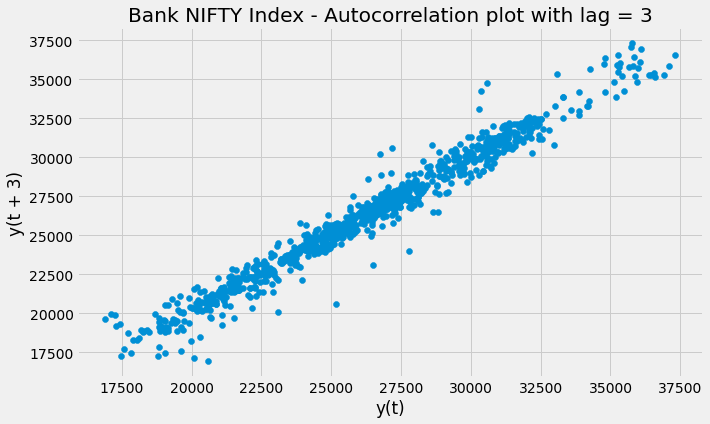

In [15]:
plt.figure()
lag_plot(df['Close'], lag=3)
plt.title('Bank NIFTY Index - Autocorrelation plot with lag = 3')
plt.show()

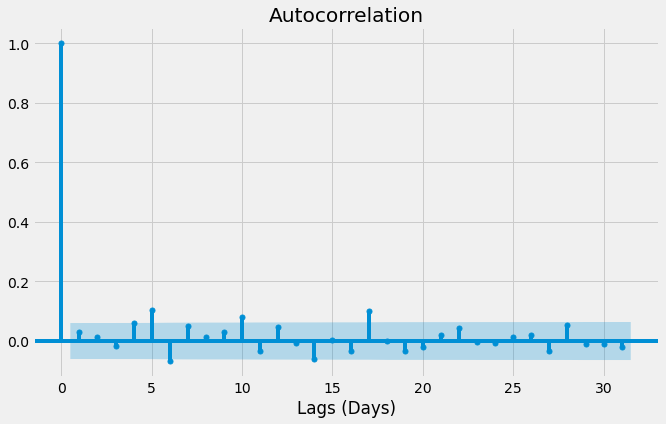

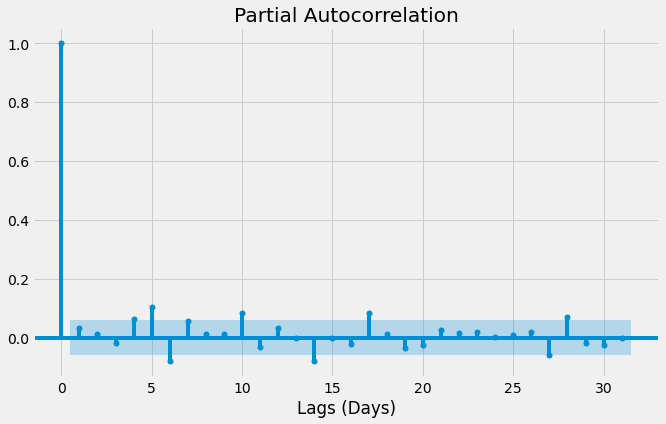

In [16]:
plot_acf(y_diff_1)
plt.xlabel('Lags (Days)')
plt.show()
plot_pacf(y_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

In [17]:
y_detrend.dropna(how='any',inplace=True)
y_detrend

Date
2017-01-11    1.867716
2017-01-12    1.366991
2017-01-13    1.150891
2017-01-16    1.267349
2017-01-17    0.906762
                ...   
2021-04-12   -1.943159
2021-04-13   -0.669865
2021-04-15   -0.117644
2021-04-16   -0.201887
2021-04-19   -0.961045
Name: Close, Length: 1046, dtype: float64

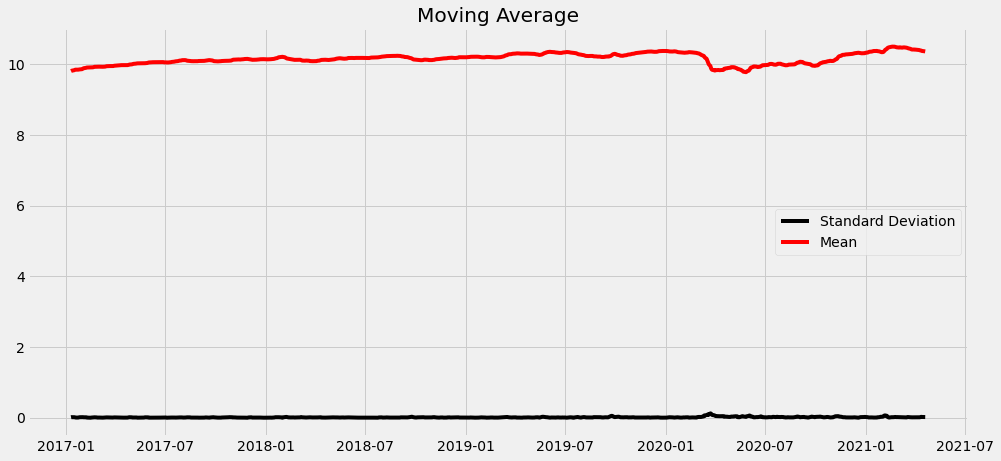

In [18]:
rcParams['figure.figsize'] = 15, 7
df_log = np.log(y)
moving_avg = df_log.rolling(7).mean()
std_dev = df_log.rolling(7).std()
ax.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [19]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

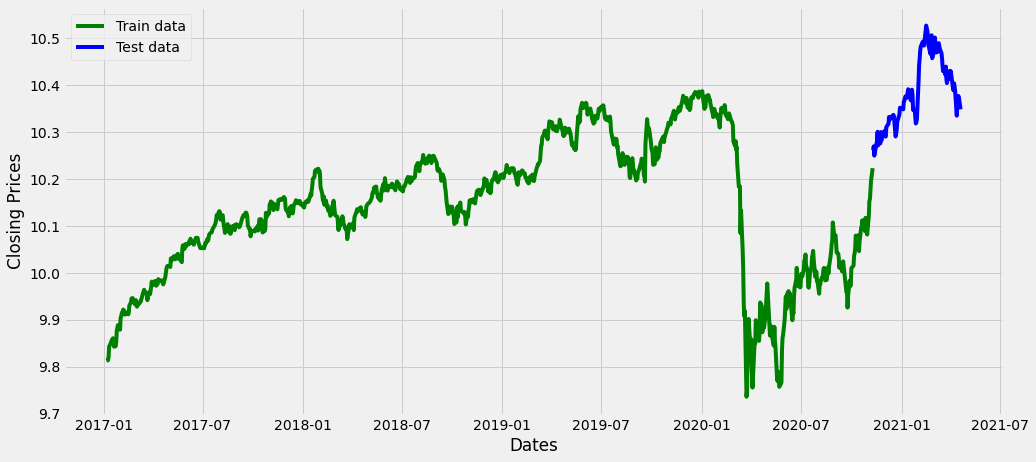

In [20]:
#Splitting the data
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(15,7))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend();

In [21]:
#Model fitting
smodel = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5051.584, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5049.713, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5049.713, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5052.930, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5053.744, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5045.725, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5045.725, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5047.731, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5047.727, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5043.729, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5052.139, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.970 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

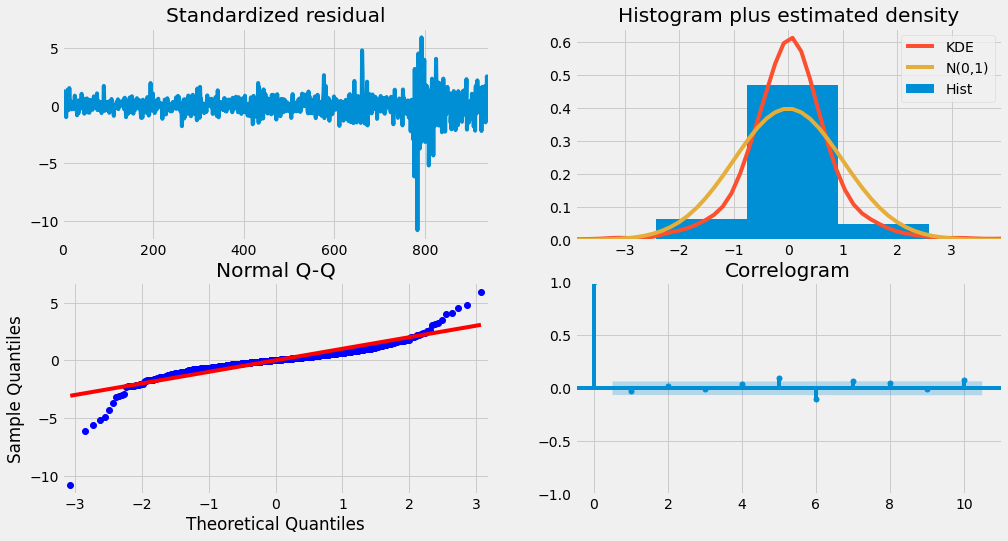

In [22]:
smodel.plot_diagnostics(figsize=(15,8))
plt.show()

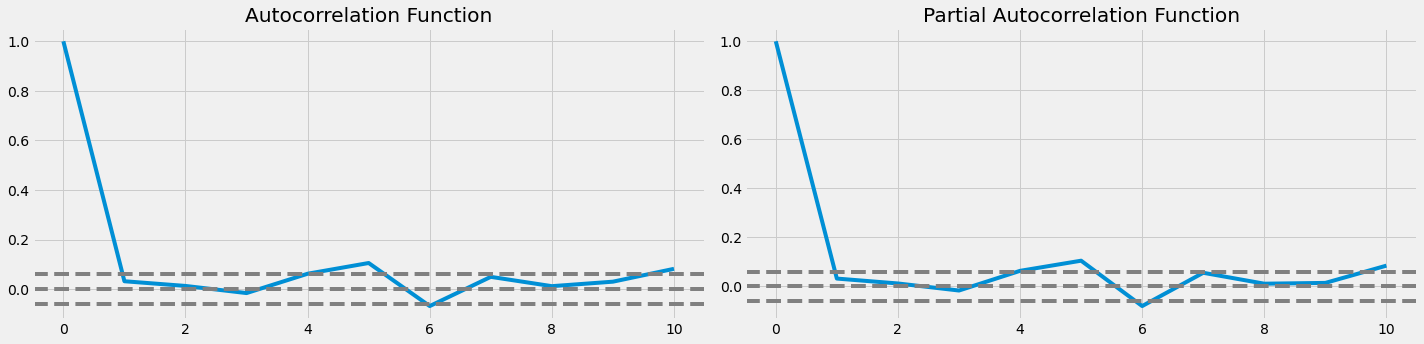

In [23]:
lag_acf = acf(y_diff_1, nlags=10)
lag_pacf = pacf(y_diff_1, nlags=10, method='ols')
plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff_1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff_1)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [24]:
model = ARIMA(train_data, order=(1,1,1))  
fitted1 = model.fit(disp=-1)
print(fitted1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  942
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2530.872
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 19 Apr 2021   AIC                          -5053.744
Time:                        18:54:12   BIC                          -5034.352
Sample:                             1   HQIC                         -5046.353
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.001      0.795      0.427      -0.001       0.002
ar.L1.D.Close    -0.8721      0.068    -12.832      0.000      -1.005      -0.739
ma.L1.D.Close     0.9117      0.057     

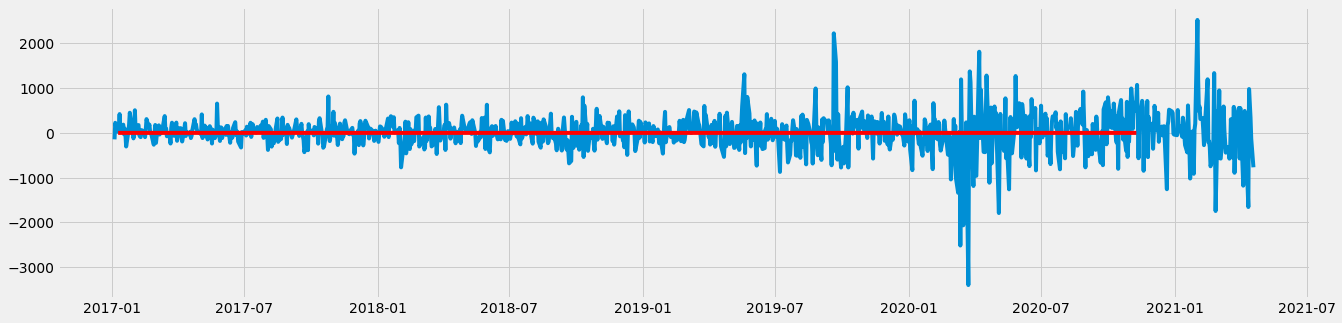

In [25]:
model = ARIMA(train_data, order=(0,1,1))  
results_AR = model.fit()  
plt.figure(figsize=(20,5))
plt.plot(y_diff_1)
plt.plot(results_AR.fittedvalues, color='red')

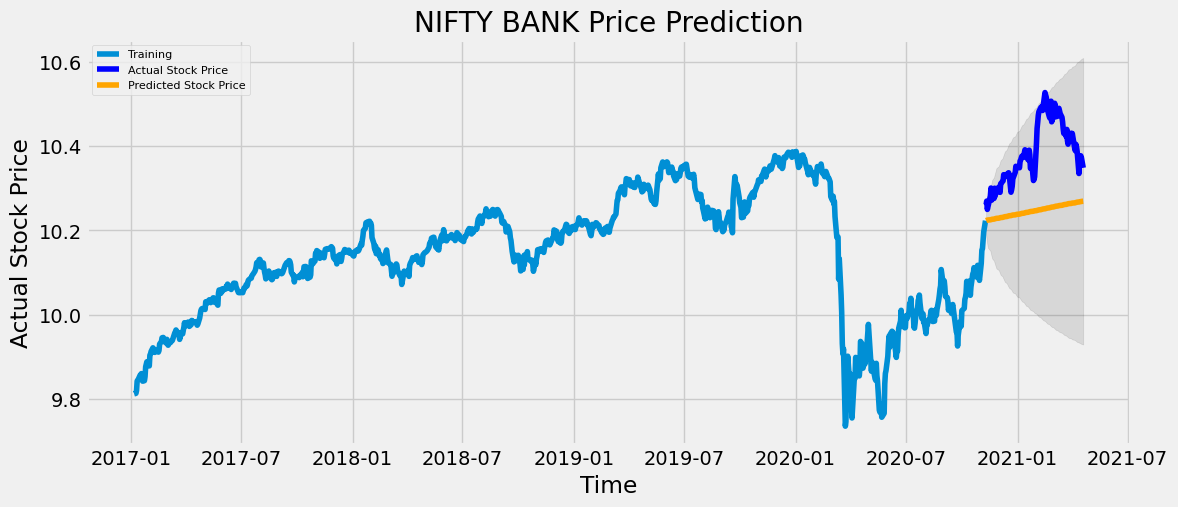

In [26]:
# Forecast
fc, se, conf = fitted1.forecast(test_data.shape[0], alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NIFTY BANK Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [27]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.024123032497141518
MAE: 0.1405651794735542
RMSE: 0.15531591192515182


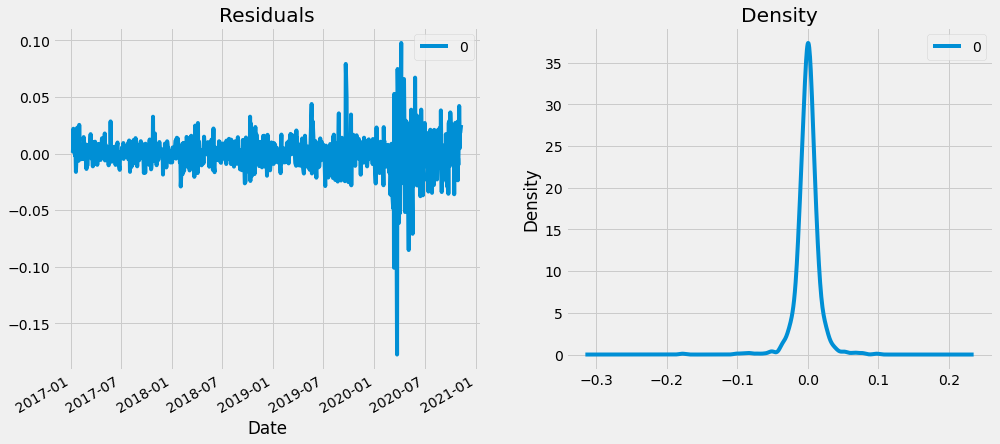

In [28]:
# Plotting residual errors
residuals = pd.DataFrame(fitted1.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

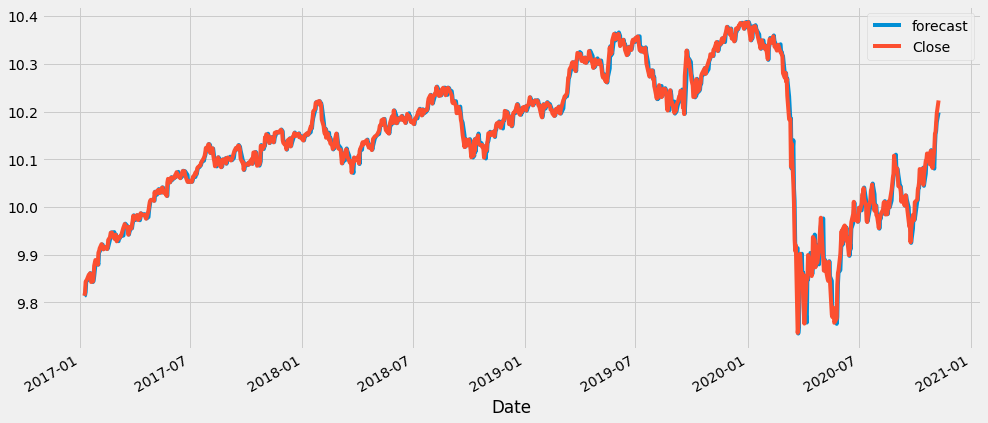

In [29]:
fitted1.plot_predict(dynamic=False)
plt.show()

In [30]:
# Sentiment Analysis

In [31]:
now = dt.date.today()
now = now.strftime('%m-%d-%Y')
yesterday = dt.date.today() - dt.timedelta(days = 2)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/utkarshsinghal06/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Please provide the name of the Company or a Ticker: Bank Nifty
               Date                  Media  \
0       2 hours ago           Zee Business   
1       9 hours ago          IndiaInfoline   
2  th · 2 hours ago  The Financial Express   
3         1 day ago                   Mint   
4        2 days ago           Zee Business   
5        2 days ago                   Mint   
6       3 hours ago            Goodreturns   
7       9 hours ago           Moneycontrol   
8       8 hours ago           Moneycontrol   
9      10 hours ago           Zee Business   

                                               Title  \
0  Stock market volatility: Anil Singhvi reveals ...   
1  Markets lower amid Covid concerns; Sensex dips...   
2  Share Market Highlights: Sensex closes 882 poi...   
3  Nifty, Bank Nifty levels to watch next week, s...   
4  Stock Market Outlook: Anil Singhvi reveals Nif...   
5  HDFC Bank share price may show weakness, say e...   
6   Nifty Ends 258 Points Lower As Cov

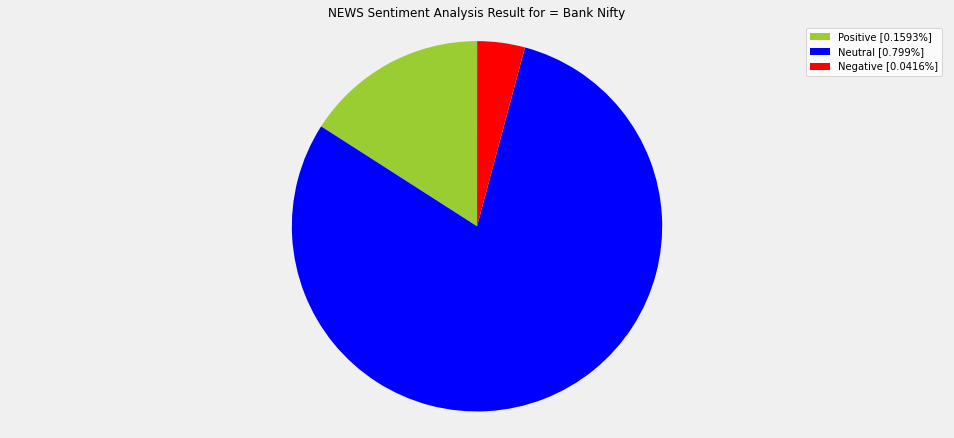

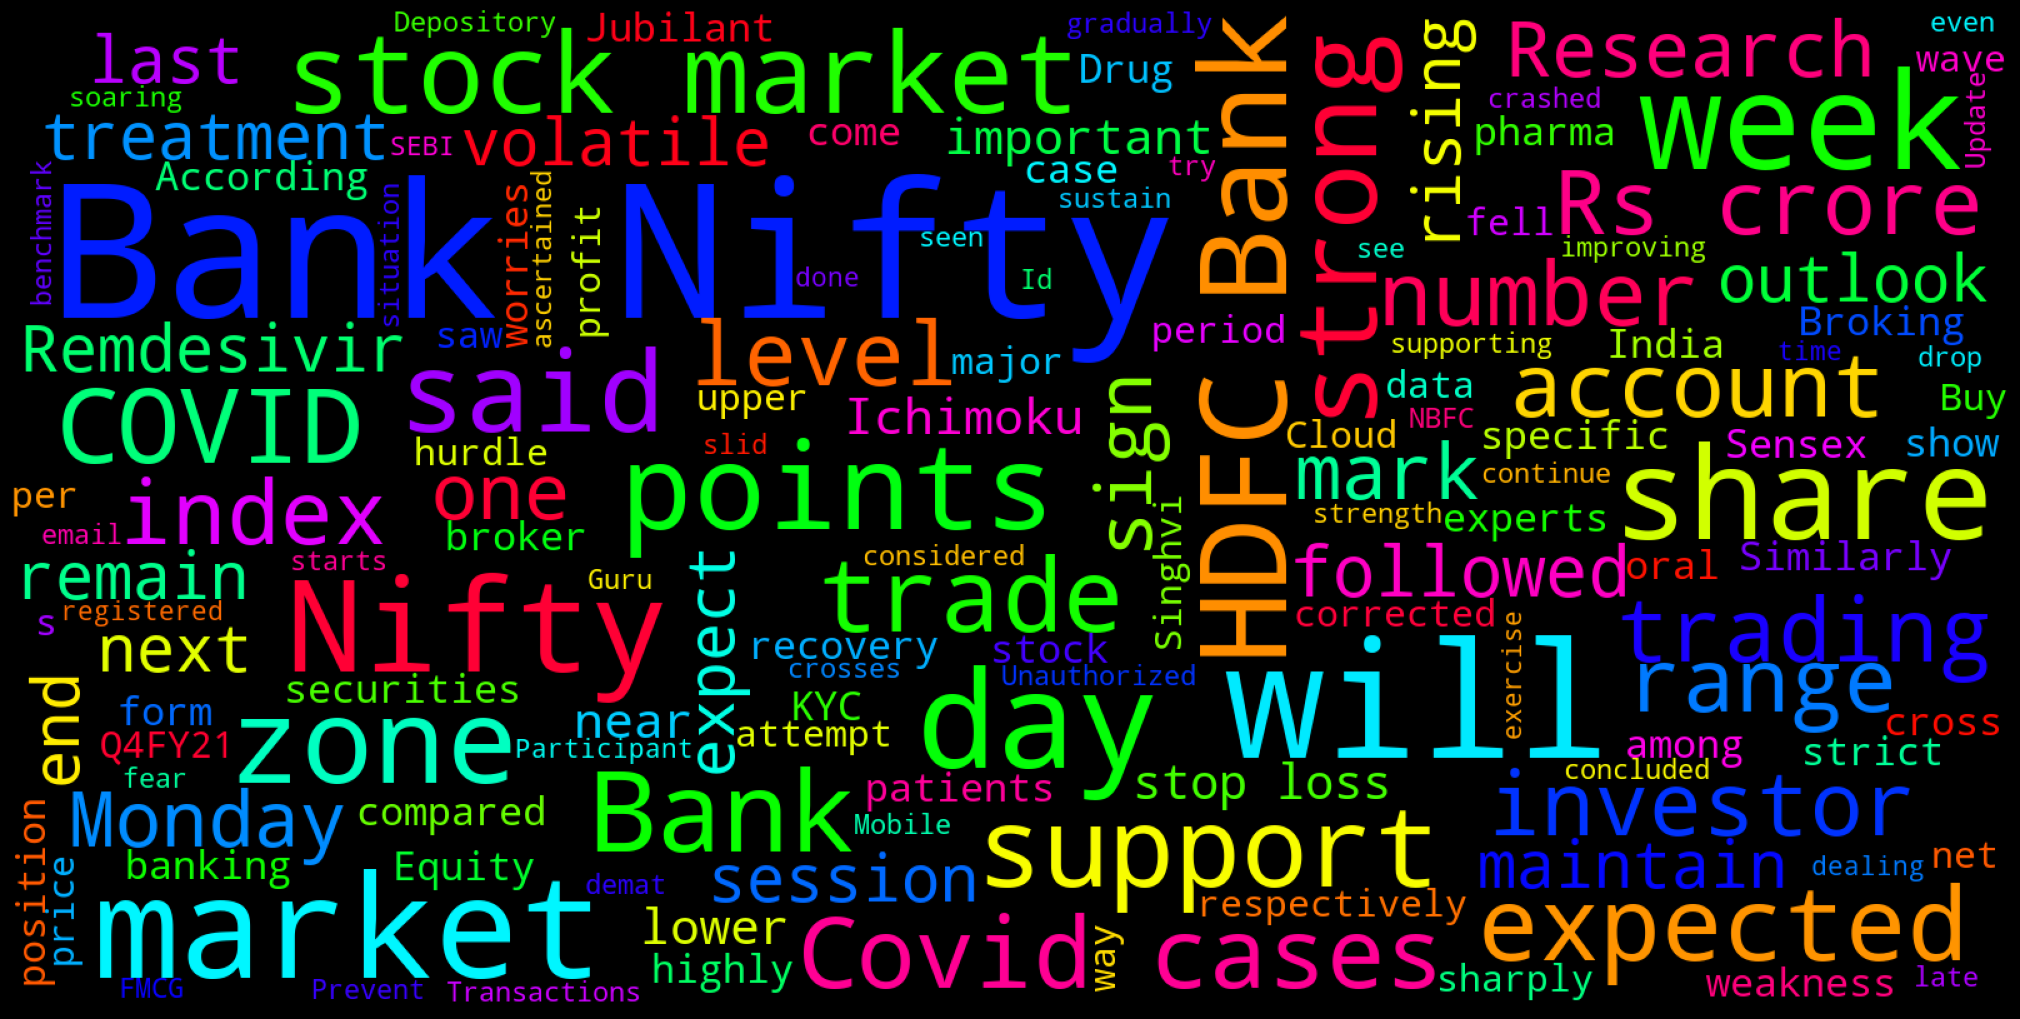

In [32]:
company_name = input("Please provide the name of the Company or a Ticker: ")

googlenews = GoogleNews(start=yesterday,end=now)
googlenews.search(company_name)
result = googlenews.result()
df = pd.DataFrame(result)
try:
    list =[]
    for ind in df.index:
        dict = {}
        article = Article(df['link'][ind],config=config)
        article.download()
        article.parse()
        article.nlp()
        dict['Date']=df['date'][ind]
        dict['Media']=df['media'][ind]
        dict['Title']=article.title
        dict['Article']=article.text
        dict['Summary']=article.summary
        dict['Key_words']=article.keywords
        list.append(dict)
    news_df=pd.DataFrame(list)
    print(news_df)

    analyzer = SentimentIntensityAnalyzer()

    news_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in news_df['Summary']]
    news_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in news_df['Summary']]
    news_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in news_df['Summary']]
    news_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in news_df['Summary']]

    # Taking averages of sentiment score columns
    N_avg_compound = np.average(news_df['compound'])
    N_avg_neg = np.average(news_df['neg']) 
    N_avg_neu = np.average(news_df['neu'])
    N_avg_pos = np.average(news_df['pos'])

    print("Positive Sentiment:", '%.2f' % N_avg_pos, end='\n*')
    print("Neutral Sentiment:", '%.2f' % N_avg_neu, end='\n*')
    print("Negative Sentiment:", '%.2f' % N_avg_neg, end='\n*')
    print("Compound Sentiment:", '%.2f' % N_avg_compound, end='\n')

    #Creating PieCart
    labels = ['Positive ['+str(N_avg_pos)+'%]' , 'Neutral ['+str(N_avg_neu)+'%]','Negative ['+str(N_avg_neg)+'%]']
    sizes = [N_avg_pos, N_avg_neu, N_avg_neg]
    colors = ['yellowgreen', 'blue','red']
    fig, ax = plt.subplots()
    patches, texts = ax.pie(sizes,colors=colors, startangle=90)
    plt.style.use('default')
    ax.legend(labels)
    ax.set_title("NEWS Sentiment Analysis Result for = "+company_name+"" )
    ax.axis('equal')
    print(fig)

    # word cloud visualization
    def news_cloud(text):
        stopwords = set(STOPWORDS)
        N_allWords = ' '.join([nws for nws in text])
        newsCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='hsv').generate(N_allWords)
        fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
        plt.imshow(newsCloud)
        ax.axis("off")
        fig.tight_layout(pad=0)
        print(fig)

    print('Wordcloud for ' + company_name)
    news_cloud(news_df['Summary'].values)

except Exception as e:
    print("exception occurred:" + str(e))


